In [11]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score


from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform

In [3]:
raw_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Train_raw.csv')
raw_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Test_raw.csv')

Adasyn_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Adasyn_train.csv')
Adasyn_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Adasyn_test.csv')

Nearmiss_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Nearmiss_train.csv')
Nearmiss_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Nearmiss_test.csv')

ROS_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/ROS_train.csv')
ROS_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/ROS_test.csv')

RUS_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/RUS_train.csv')
RUS_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/RUS_test.csv')

SMOTETomek_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/SMOTETomek_train.csv')
SMOTETomek_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/SMOTETomek_test.csv')

In [5]:
pip install neptune-client

     |████████████████████████████████| 92kB 3.8MB/s 
     |████████████████████████████████| 829kB 14.2MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 204kB 13.4MB/s 
     |████████████████████████████████| 163kB 18.6MB/s 
     |████████████████████████████████| 133kB 20.2MB/s 
     |████████████████████████████████| 71kB 7.7MB/s 
     |████████████████████████████████| 71kB 9.1MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.4.123-py2.py3-none-any.whl size=151354 sha256=6b77fc98bee1968d94592ea5d27416f7254207fa128bc8a0cf45061902a409d7
  Stored in directory: /root/.cache/pip/wheels/ca/7b/77/702f9e0d837deca9e55080adf43b6e18489a7a2a93d17d4fa0
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=11a2774e5aa398e0e2eedd95a47dc6ba9fe43d5835cfbfe187fee9d08425b15f
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for 

In [6]:
import neptune

API_TOKEN='' #@param {type:"string"}

PROJEKT_NAME = 'DataWorkshop-Foundation/Predicting-cancellation-of-visit' 

neptune.init(
   api_token=API_TOKEN,
   project_qualified_name=PROJEKT_NAME
)

Project(DataWorkshop-Foundation/Predicting-cancellation-of-visit)

In [7]:
def model2(train, test, search, name, tags):
  
  print(search.get_params())
  y_train = train["NoShow"]
  y_test = test["NoShow"]

  X_train = train.loc[:, train.columns != 'NoShow']
  X_test = test.loc[:, test.columns != 'NoShow']
                

  
  search = search.fit(X_train, y_train)
  if 'constant' in search.get_params():
  #if search.get_params().key[0] == ('constant'):
    search.best_params_ =np.nan

  search.best_params_

  y_pred = search.predict(X_test)
  print(y_pred)
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))
  print(' f1 ', f1_score(y_test, y_pred), '\n',
        'recall', recall_score(y_test, y_pred), '\n',
        'precision', precision_score(y_test, y_pred) )

  neptune.create_experiment(
      name=name
  )

  neptune.log_metric('accuracy', accuracy)
  neptune.log_metric('f1', f1_score(y_test, y_pred))
  neptune.log_metric('recall', recall_score(y_test, y_pred))
  neptune.log_metric('precision', precision_score(y_test, y_pred))
  neptune.append_tags(tags)
  neptune.append_tags([str(search.best_params_),"Magdalena Cebula"])
  from sklearn.metrics import confusion_matrix

  conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
  print('Confusion matrix:\n', conf_mat)

  from matplotlib import pyplot as plt

  labels = ['Class 0', 'Class 1']
  fig = plt.figure()
  ax = fig.add_subplot()
  cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
  fig.colorbar(cax)
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('Expected')
  plt.show()

  neptune.log_image('Confusion_matrix ' + name, fig)
  
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, search.predict(X_test))
  print(false_positive_rate, true_positive_rate, thresholds)


  roc_auc_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred)
  neptune.log_metric('roc_auc', auc)
  fig = plt.figure()
  plt.plot(false_positive_rate,true_positive_rate,label="data 1, auc="+str(auc))
  plt.legend(loc=4)
  plt.show()
  neptune.log_image('ROC AUC ' + name, fig)
  neptune.stop()

In [12]:
logistic = LogisticRegression(tol=1e-2, max_iter=100,
                               random_state=0)
distributions = dict(C=uniform(loc=0, scale=4),
                      penalty=['l2', 'l1', 'elasticnet'],
                      solver=['newton-cg', 'lbfgs', 'liblinear'],#, 'sag', 'saga'], 
                  
                     )

In [ ]:
clf = RandomizedSearchCV(logistic, 
                          distributions,
                          scoring = 'f1',
                          random_state=0,
                          cv=5,
                          verbose=1,
                          n_jobs = -1)

{'cv': 5, 'error_score': nan, 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 100, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': 0, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.01, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.01, verbose=0,
                   warm_start=False), 'iid': 'deprecated', 'n_iter': 10, 'n_jobs': -1, 'param_distributions': {'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f16b8b689e8>, 'penalty': ['l2', 'l1', 'elasticnet'], 'solver': 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.6min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[0 0 0 ... 0 0 0]
Accuracy: 79.64%
 f1  0.028776978417266185 
 recall 0.014938886373924853 
 precision 0.3905325443786982
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-59
Confusion matrix:
 [[17362   103]
 [ 4352    66]]


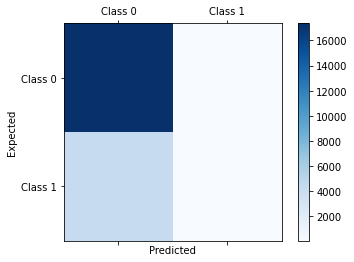

[0.         0.00589751 1.        ] [0.         0.01493889 1.        ] [2 1 0]


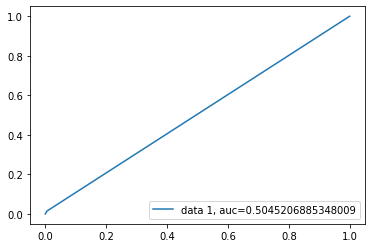

In [ ]:
model2(raw_train, raw_test, clf, "LogisticRegression", ['Logistic Regression', 'Raw', 'Randomsearch'])

{'cv': 5, 'error_score': nan, 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 100, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': 0, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.01, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.01, verbose=0,
                   warm_start=False), 'iid': 'deprecated', 'n_iter': 10, 'n_jobs': -1, 'param_distributions': {'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f16b8b689e8>, 'penalty': ['l2', 'l1', 'elasticnet'], 'solver': 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 13.8min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[0 0 0 ... 1 1 1]
Accuracy: 82.33%
 f1  0.8150101906246253 
 recall 0.7781593406593407 
 precision 0.8555247923483513
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-60
Confusion matrix:
 [[15169  2296]
 [ 3876 13596]]


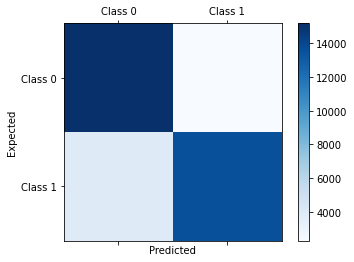

[0.         0.13146293 1.        ] [0.         0.77815934 1.        ] [2 1 0]


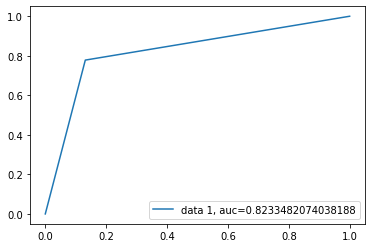

In [ ]:
model2(Adasyn_train, Adasyn_test, clf,"LogisticRegression", ['Logistic Regression', 'Adasyn', 'Randomsearch'])

{'cv': 5, 'error_score': nan, 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 100, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': 0, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.01, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.01, verbose=0,
                   warm_start=False), 'iid': 'deprecated', 'n_iter': 10, 'n_jobs': -1, 'param_distributions': {'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f16b8b689e8>, 'penalty': ['l2', 'l1', 'elasticnet'], 'solver': 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.8min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[1 1 1 ... 1 1 1]
Accuracy: 50.00%
 f1  0.6666666666666666 
 recall 1.0 
 precision 0.5
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-61
Confusion matrix:
 [[   0 4418]
 [   0 4418]]


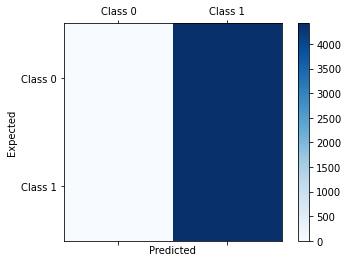

[0. 1.] [0. 1.] [2 1]


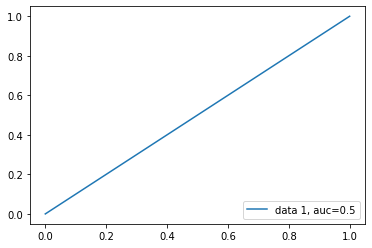

In [ ]:
model2(Nearmiss_train, Nearmiss_test,clf, "LogisticRegression", ['Logistic Regression', 'Nearmiss', 'Randomsearch'])

{'cv': 5, 'error_score': nan, 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 100, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': 0, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.01, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.01, verbose=0,
                   warm_start=False), 'iid': 'deprecated', 'n_iter': 10, 'n_jobs': -1, 'param_distributions': {'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f16b8b689e8>, 'penalty': ['l2', 'l1', 'elasticnet'], 'solver': 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 28.1min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[1 0 0 ... 0 0 1]
Accuracy: 62.74%
 f1  0.6086119797931201 
 recall 0.5794446034926997 
 precision 0.6408713824330314
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-63
Confusion matrix:
 [[11794  5671]
 [ 7345 10120]]


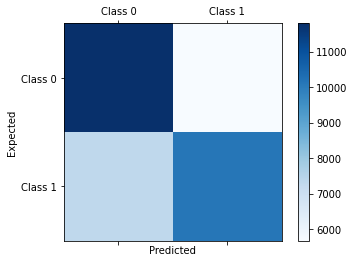

[0.         0.32470656 1.        ] [0.        0.5794446 1.       ] [2 1 0]


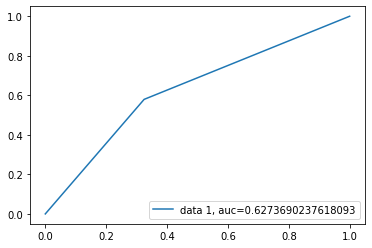

In [ ]:
model2(ROS_train, ROS_test,clf, "LogisticRegression", ['Logistic Regression', 'ROS', 'Randomsearch'])

{'cv': 5, 'error_score': nan, 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 100, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': 0, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.01, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.01, verbose=0,
                   warm_start=False), 'iid': 'deprecated', 'n_iter': 10, 'n_jobs': -1, 'param_distributions': {'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f16b8b689e8>, 'penalty': ['l2', 'l1', 'elasticnet'], 'solver': 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.4min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[0 1 0 ... 0 0 1]
Accuracy: 62.30%
 f1  0.6034051672818194 
 recall 0.5735626980534179 
 precision 0.6365234865611655
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-64
Confusion matrix:
 [[2971 1447]
 [1884 2534]]


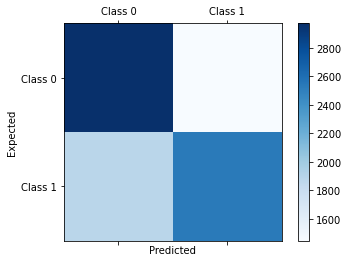

[0.         0.32752377 1.        ] [0.        0.5735627 1.       ] [2 1 0]


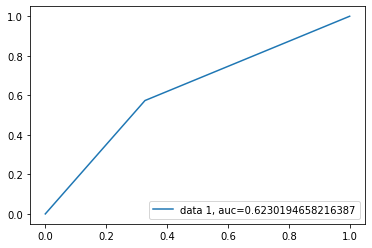

In [ ]:
model2(RUS_train, RUS_test, clf,"LogisticRegression", ['Logistic Regression', 'RUS', 'Randomsearch'])

{'cv': 5, 'error_score': nan, 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 100, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': 0, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.01, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.01, verbose=0,
                   warm_start=False), 'iid': 'deprecated', 'n_iter': 10, 'n_jobs': -1, 'param_distributions': {'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f16b8b689e8>, 'penalty': ['l2', 'l1', 'elasticnet'], 'solver': 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 11.4min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[0 0 0 ... 1 1 1]
Accuracy: 83.87%
 f1  0.8318481657215602 
 recall 0.7977212192956497 
 precision 0.8690255500926896
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-65
Confusion matrix:
 [[11891  1625]
 [ 2734 10782]]


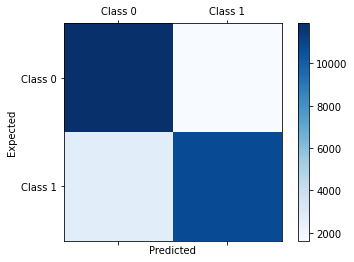

[0.         0.12022788 1.        ] [0.         0.79772122 1.        ] [2 1 0]


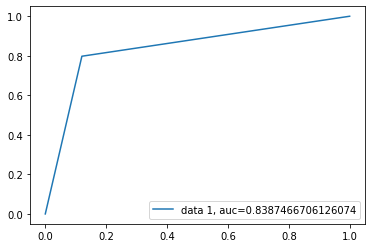

In [ ]:
model2(SMOTETomek_train, SMOTETomek_test, clf,"LogisticRegression", ['Logistic Regression', 'SMOTETomek', 'Randomsearch'])

In [14]:
param_grid = dict(  penalty=['l2', 'l1', 'elasticnet'],
                    solver=['newton-cg', 'lbfgs', 'liblinear'], 
 )



In [15]:
grid = GridSearchCV(estimator=logistic, param_grid=param_grid, scoring='f1', verbose=1, n_jobs=-1)

{'cv': None, 'error_score': nan, 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 100, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': 0, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.01, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.01, verbose=0,
                   warm_start=False), 'iid': 'deprecated', 'n_jobs': -1, 'param_grid': {'penalty': ['l2', 'l1', 'elasticnet'], 'solver': ['newton-cg', 'lbfgs', 'liblinear']}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_sc

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  8.6min finished
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[0 0 0 ... 0 0 0]
Accuracy: 79.64%
 f1  0.028776978417266185 
 recall 0.014938886373924853 
 precision 0.3905325443786982
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-72
Confusion matrix:
 [[17362   103]
 [ 4352    66]]


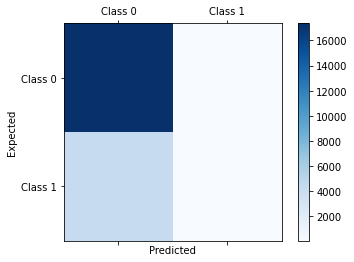

[0.         0.00589751 1.        ] [0.         0.01493889 1.        ] [2 1 0]


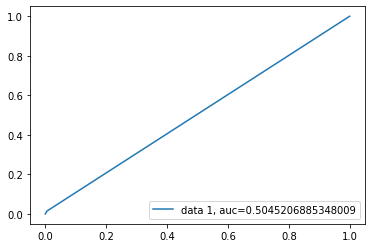

In [23]:
model2(raw_train, raw_test, grid, "LogisticRegression", ['Logistic Regression', 'Raw', 'GridSearch'])

{'cv': None, 'error_score': nan, 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 100, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': 0, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.01, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.01, verbose=0,
                   warm_start=False), 'iid': 'deprecated', 'n_jobs': -1, 'param_grid': {'penalty': ['l2', 'l1', 'elasticnet'], 'solver': ['newton-cg', 'lbfgs', 'liblinear']}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_sc

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 13.7min finished


[0 0 0 ... 1 1 1]
Accuracy: 82.34%
 f1  0.8150479616306955 
 recall 0.7781021062271062 
 precision 0.8556772406847936
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-73
Confusion matrix:
 [[15172  2293]
 [ 3877 13595]]


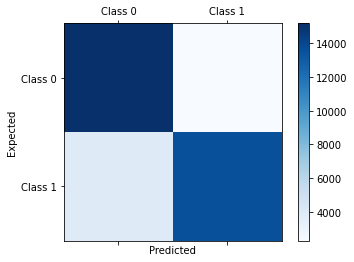

[0.         0.13129115 1.        ] [0.         0.77810211 1.        ] [2 1 0]


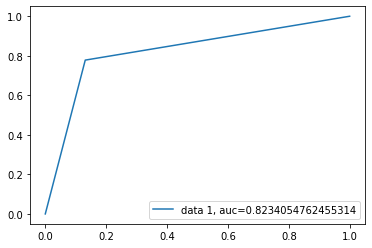

In [26]:
model2(Adasyn_train, Adasyn_test, grid, "LogisticRegression", ['Logistic Regression', 'Adasyn', 'GridSearch'])

{'cv': None, 'error_score': nan, 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 100, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': 0, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.01, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.01, verbose=0,
                   warm_start=False), 'iid': 'deprecated', 'n_jobs': -1, 'param_grid': {'penalty': ['l2', 'l1', 'elasticnet'], 'solver': ['newton-cg', 'lbfgs', 'liblinear']}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_sc

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  5.0min finished
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[1 1 1 ... 1 1 1]
Accuracy: 50.00%
 f1  0.6666666666666666 
 recall 1.0 
 precision 0.5
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-74
Confusion matrix:
 [[   0 4418]
 [   0 4418]]


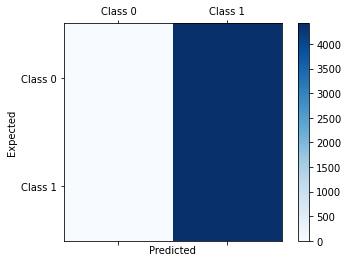

[0. 1.] [0. 1.] [2 1]


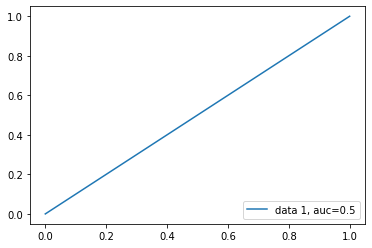

In [27]:
model2(Nearmiss_train, Nearmiss_test, grid, "LogisticRegression", ['Logistic Regression', 'Nearmiss', 'GridSearch'])

{'cv': None, 'error_score': nan, 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 100, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': 0, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.01, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.01, verbose=0,
                   warm_start=False), 'iid': 'deprecated', 'n_jobs': -1, 'param_grid': {'penalty': ['l2', 'l1', 'elasticnet'], 'solver': ['newton-cg', 'lbfgs', 'liblinear']}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_sc

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed: 22.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 27.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[1 0 0 ... 0 0 1]
Accuracy: 62.74%
 f1  0.6086721193168151 
 recall 0.5795018608645863 
 precision 0.6409347096447343
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-77
Confusion matrix:
 [[11795  5670]
 [ 7344 10121]]


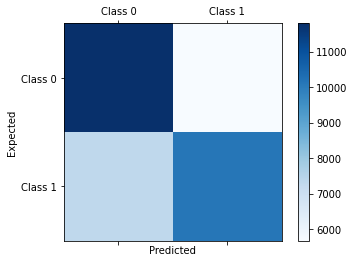

[0.        0.3246493 1.       ] [0.         0.57950186 1.        ] [2 1 0]


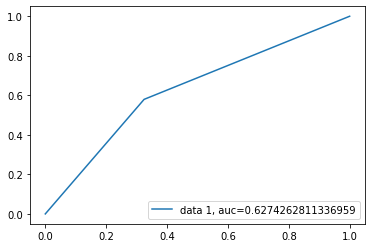

In [28]:
model2(ROS_train, ROS_test,grid, "LogisticRegression", ['Logistic Regression', 'ROS', 'GridSearch'])

In [ ]:
model2(RUS_train, RUS_test, grid, "LogisticRegression", ['Logistic Regression', 'RUS', 'GridSearch'])

In [ ]:
model2(SMOTETomek_train, SMOTETomek_test, grid, "LogisticRegression", ['Logistic Regression', 'SmoteTomek', 'GridSearch'])

In [16]:
from sklearn.dummy import DummyClassifier

{'constant': None, 'random_state': None, 'strategy': 'most_frequent'}
[0 0 0 ... 0 0 0]
Accuracy: 79.81%
 f1  0.0 
 recall 0.0 
 precision 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-66


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix:
 [[17465     0]
 [ 4418     0]]


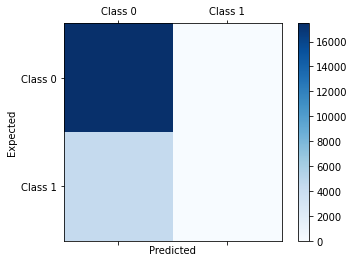

[0. 1.] [0. 1.] [1 0]


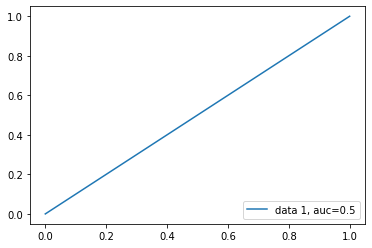

In [17]:
model2(raw_train, raw_test, DummyClassifier(strategy="most_frequent"), "LogisticRegression", ['Logistic Regression', 'Raw', 'DummyClassifier'])

{'constant': None, 'random_state': None, 'strategy': 'most_frequent'}
[0 0 0 ... 0 0 0]
Accuracy: 49.99%
 f1  0.0 
 recall 0.0 
 precision 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-67
Confusion matrix:
 [[17465     0]
 [17472     0]]


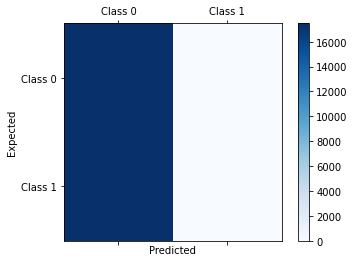

[0. 1.] [0. 1.] [1 0]


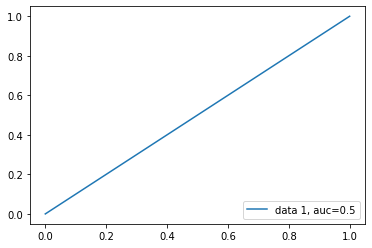

In [18]:
model2(Adasyn_train, Adasyn_test, DummyClassifier(strategy="most_frequent"), "LogisticRegression", ['Logistic Regression', 'Adasyn', 'DummyClassifier'])

{'constant': None, 'random_state': None, 'strategy': 'most_frequent'}
[0 0 0 ... 0 0 0]
Accuracy: 50.00%
 f1  0.0 
 recall 0.0 
 precision 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-68
Confusion matrix:
 [[4418    0]
 [4418    0]]


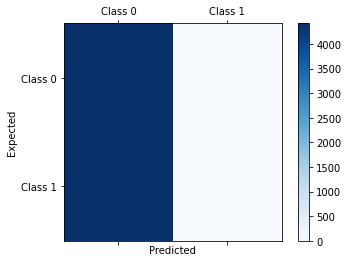

[0. 1.] [0. 1.] [1 0]


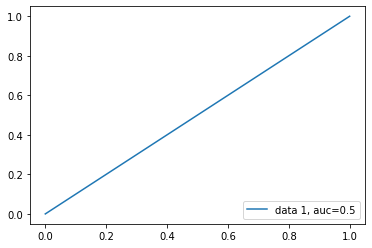

In [19]:
model2(Nearmiss_train, Nearmiss_test, DummyClassifier(strategy="most_frequent"), "LogisticRegression", ['Logistic Regression', 'Nearmiss', 'DummyClassifier'])

{'constant': None, 'random_state': None, 'strategy': 'most_frequent'}
[0 0 0 ... 0 0 0]
Accuracy: 50.00%
 f1  0.0 
 recall 0.0 
 precision 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-69
Confusion matrix:
 [[17465     0]
 [17465     0]]


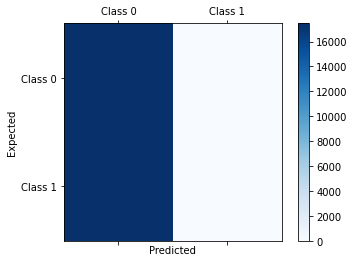

[0. 1.] [0. 1.] [1 0]


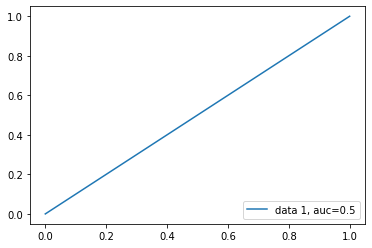

In [20]:
model2(ROS_train, ROS_test, DummyClassifier(strategy="most_frequent"), "LogisticRegression", ['Logistic Regression', 'ROS', 'DummyClassifier'])

{'constant': None, 'random_state': None, 'strategy': 'most_frequent'}
[0 0 0 ... 0 0 0]
Accuracy: 50.00%
 f1  0.0 
 recall 0.0 
 precision 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-70
Confusion matrix:
 [[4418    0]
 [4418    0]]


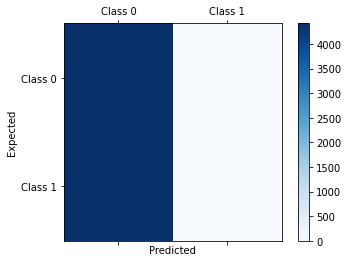

[0. 1.] [0. 1.] [1 0]


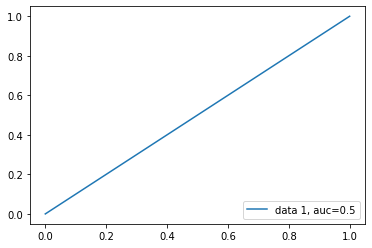

In [21]:
model2(RUS_train, RUS_test, DummyClassifier(strategy="most_frequent"), "LogisticRegression", ['Logistic Regression', 'RUS', 'DummyClassifier'])

{'constant': None, 'random_state': None, 'strategy': 'most_frequent'}
[0 0 0 ... 0 0 0]
Accuracy: 50.00%
 f1  0.0 
 recall 0.0 
 precision 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-71
Confusion matrix:
 [[13516     0]
 [13516     0]]


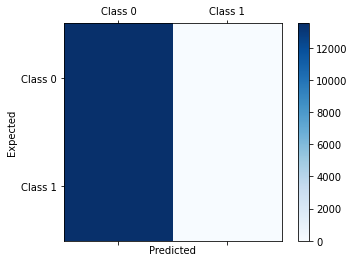

[0. 1.] [0. 1.] [1 0]


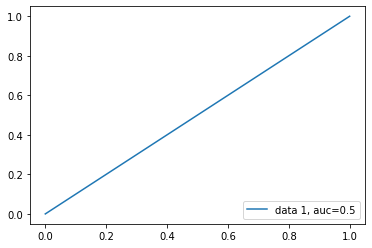

In [22]:
model2(SMOTETomek_train, SMOTETomek_test, DummyClassifier(strategy="most_frequent"), "LogisticRegression", ['Logistic Regression', 'SmoteTomek', 'DummyClassifier'])